In [1]:
import pandas as pd
import numpy as np
from atom3d.datasets import load_dataset
from tqdm import tqdm
import collections as col
from collapse.utils import pdb_from_fname, deserialize
from collapse.atom_info import aa_to_letter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
label_dict = {'LP/P': 'pathogenic', 'LB/B': 'benign', 'US': 'unknown'}
mut_data = []
with open('data/humsavar.txt') as f:
    for i in range(44):
        next(f)
    for l in f:
        gene, uniprot, _, variant, lab, snp, dz = l[:12].strip(), l[12:23].strip(), l[23:35].strip(), l[35:50].strip(), l[50:59].strip(), l[59:74].strip(), l[74:].strip()
        if lab not in label_dict:
            continue
        label = label_dict[lab]
        wt = variant[2:5]
        mut = variant[-3:]
        pos = int(variant[5:-3])
        mut_data.append([uniprot, wt, pos, mut, label, dz])
mut_data = pd.DataFrame(mut_data, columns=['uniprot', 'wt', 'pos', 'mut', 'label', 'disease'])

In [6]:
uniprot_rows = mut_data.groupby('uniprot').groups

In [3]:
mut_data

,uniprot,wt,pos,mut,label,disease
0,P04217,His,52,Arg,benign,-
1,P04217,His,395,Arg,benign,-
2,Q9NQ94,Val,555,Met,benign,-
3,Q9NQ94,Ala,558,Ser,benign,-
4,P01023,Arg,704,His,benign,-
...,...,...,...,...,...,...
82407,Q8N402,Thr,131,Pro,benign,-
82408,Q96M66,Arg,37,His,benign,-
82409,Q96M66,Arg,171,Ser,benign,-
82410,Q9N2K0,Val,81,Leu,benign,-


In [4]:
mut_data.value_counts('label')

label
benign        39654
pathogenic    32627
unknown       10131
Name: count, dtype: int64

In [5]:
mut_data.uniprot.nunique()

13055

In [4]:
k = 50000
clusterer = deserialize(f'data/pdb100_cluster_fit_{k}.pkl')

In [5]:
human_proteome = load_dataset('/scratch/users/aderry/collapse/datasets/af2_human_proteome/full', 'lmdb')
len(human_proteome)

21834

In [105]:
cluster_cts = np.zeros(k)
cluster_mutations = col.defaultdict(list)
uniprot_clusters = {}
cluster_refs = col.defaultdict(list)
for item in tqdm(human_proteome):
    if item is None:
        continue
    afid, _ = pdb_from_fname(item['id'])
    
    high_conf_idx = np.array(item['confidence']) >= 70
    if np.sum(high_conf_idx) == 0:
        continue
    af_resids = np.array(item['resids'])[high_conf_idx]
    embeddings = item['embeddings'][high_conf_idx]
    
    clusters = clusterer.predict(embeddings)
    uniprot_clusters[afid] = af_resids, clusters
    np.add.at(cluster_cts, clusters, 1)
    if afid in uniprot_rows:
        wt = mut_data.loc[uniprot_rows[afid], 'wt'].values
        pos = mut_data.loc[uniprot_rows[afid], 'pos'].values
        mut = mut_data.loc[uniprot_rows[afid], 'mut'].values
        labels = mut_data.loc[uniprot_rows[afid], 'label'].values
        resids = [aa_to_letter(r.upper()) + str(p) for r,p in zip(wt, pos)]
        resids_to_labels = dict(zip(resids, labels))
        var_idx = np.isin(af_resids, resids)
        var_resids = af_resids[var_idx]
        var_labels = [resids_to_labels[v] for v in var_resids]
        var_clusters = clusters[var_idx]
        for i in range(len(var_clusters)):
            cluster_mutations[var_clusters[i]].append(var_labels[i])
            cluster_refs[var_clusters[i]].append(afid + '_' + var_resids[i])

100%|██████████| 21834/21834 [3:31:24<00:00,  1.72it/s]   


In [106]:
from collapse.utils import serialize
serialize(cluster_cts, f'data/af2_human_cluster_cts_{k}.pkl')
serialize(cluster_mutations, f'data/af2_human_cluster_variants_{k}.pkl')
serialize(uniprot_clusters, f'data/af2_human_cluster_resids_{k}.pkl')
serialize(cluster_refs, f'data/af2_human_cluster_variant_refs_{k}.pkl')

In [7]:
k = 50000
cluster_cts = deserialize(f'data/af2_human_cluster_cts_{k}.pkl')
cluster_mutations = deserialize(f'data/af2_human_cluster_variants_{k}.pkl')
uniprot_clusters = deserialize(f'data/af2_human_cluster_resids_{k}.pkl')
cluster_refs = deserialize(f'data/af2_human_cluster_variant_refs_{k}.pkl')

In [8]:
len(cluster_mutations)

23075

In [108]:
cluster_cts[24491]

2980.0

In [109]:
cluster_mutations[24491]

['benign',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'pathogenic',
 'benign',
 'unknown',
 'benign',
 'pathogenic']

In [9]:
label_cts = {'benign': 0, 'pathogenic': 0, 'unknown': 0}
for _,v in cluster_mutations.items():
    ct = col.Counter(v)
    for k in ct:
        label_cts[k] += ct[k]
label_cts

{'benign': 20377, 'pathogenic': 22571, 'unknown': 5419}

In [10]:
M = np.sum(list(label_cts.values()))
n = label_cts['pathogenic']
N = cluster_cts[24491]
k = col.Counter(cluster_mutations[24491])['pathogenic']
pval = hypergeom.sf(k, M, n, N)
print(pval)

1.0


In [11]:
from scipy.stats import hypergeom

In [12]:
M = np.sum(list(label_cts.values()))
n = label_cts['pathogenic']

cluster_path_pvals = {}
for clust, muts in cluster_mutations.items():
    N = len(muts)
    k = col.Counter(muts)['pathogenic']
    pval = hypergeom.sf(k, M, n, N) 
    pval_corr = pval * len(cluster_mutations)
    cluster_path_pvals[clust] = [pval, pval_corr, muts, float(k) / N]

In [13]:
path_enrich = pd.DataFrame(cluster_path_pvals).T
path_enrich.columns = ['pval', 'pval_corr', 'mutations', 'pct_pathogenic']
path_enrich['n_mut'] = path_enrich.mutations.apply(len)

In [14]:
path_enrich.sort_values(['pval_corr', 'n_mut'], ascending=[True, False]).head(20)

,pval,pval_corr,mutations,pct_pathogenic,n_mut
7043,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,19
31037,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,9
23310,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,9
39542,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,8
48393,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,8
31407,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,8
160,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,7
48563,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,7
8771,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,7
47510,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,7


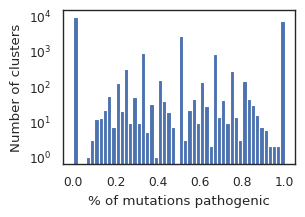

In [20]:
sns.set(context='paper', style='white')
plt.figure(figsize=(3,2))
plt.hist(path_enrich['pct_pathogenic'], bins=50)
plt.xlabel('% of mutations pathogenic')
plt.ylabel('Number of clusters')
plt.yscale('log')
plt.savefig('./figures/cluster_pct_pathogenic.svg', dpi=300, bbox_inches='tight', format='svg')

In [21]:
(path_enrich['pct_pathogenic'] > 0).sum()

13569

In [19]:
sig = path_enrich[(path_enrich['pval_corr'] < 0.05) & (path_enrich['n_mut'] > 1)]
len(sig), len(path_enrich), len(sig[sig['n_mut'] > 5])

(2056, 23075, 43)

In [18]:
col.Counter(sig['n_mut'])

Counter({2: 1406,
         3: 418,
         4: 128,
         5: 61,
         6: 21,
         7: 10,
         8: 3,
         9: 2,
         31: 1,
         85: 1,
         20: 1,
         35: 1,
         65: 1,
         32: 1,
         19: 1})

In [21]:
pathogenic_clusters_5 = sig[sig['n_mut'] >= 5].index.tolist()
pathogenic_clusters = sig.index.tolist()

In [20]:
sig[sig['n_mut'] >= 5].sort_values('n_mut', ascending=False)

,pval,pval_corr,mutations,pct_pathogenic,n_mut
6044,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",0.964706,85
12238,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",0.984615,65
26414,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",0.971429,35
6563,0.000002,0.040722,"[pathogenic, pathogenic, benign, pathogenic, p...",0.84375,32
11387,0.0,0.009237,"[pathogenic, pathogenic, pathogenic, pathogeni...",0.870968,31
...,...,...,...,...,...
41532,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,5
18464,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,5
37660,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,5
20221,0.0,0.0,"[pathogenic, pathogenic, pathogenic, pathogeni...",1.0,5


In [37]:
cluster_id = 23310
cluster_mut_df = []
for uniprot_mut, lab in list(zip(cluster_refs[cluster_id], cluster_mutations[cluster_id])):
    # print('\n' + uniprot + '\n' + '------')
    uniprot, resid = uniprot_mut.split('_')
    loc = int(resid[1:])
    muts = mut_data.loc[uniprot_rows[uniprot]]
    muts = muts[muts.pos == loc]
    cluster_mut_df.append(muts)
cluster_mut_df = pd.concat(cluster_mut_df)

In [38]:
cluster_mut_df['variant'] = cluster_mut_df['wt'].apply(lambda x: aa_to_letter(x.upper())) + cluster_mut_df['pos'].astype(str) + cluster_mut_df['mut'].apply(lambda x: aa_to_letter(x.upper()))

In [39]:
cluster_variants_df = pd.DataFrame([cluster_mut_df.groupby(['uniprot'])['variant'].apply(list), cluster_mut_df.groupby(['uniprot'])['label'].apply(list)]).T

In [40]:
cluster_variants_df

,variant,label
uniprot,,
P04629,[Y359C],[pathogenic]
P11362,"[Y99C, Y228D, Y339C]","[pathogenic, pathogenic, pathogenic]"
P21802,"[Y105C, Y340H, Y340C]","[pathogenic, pathogenic, pathogenic]"
Q0ZGT2,[Y652C],[pathogenic]
Q14896,[Y237S],[pathogenic]
Q86TC9,[Y339F],[pathogenic]


In [29]:
cluster_variants_df.to_csv(f'data/cluster{cluster_id}_variants.csv')

In [32]:
for u, df in cluster_mut_df.groupby('uniprot'):
    print(df)

      uniprot   wt  pos  mut       label  \
22379  P22413  Asp  804  His  pathogenic   

                                                 disease variant  
22379  Arterial calcification of infancy, generalized...   D804H  
      uniprot   wt  pos  mut       label  \
16477  P49747  Asp  290  Asn  pathogenic   
16511  P49747  Asp  290  Gly  pathogenic   
16514  P49747  Asp  317  Gly  pathogenic   
16515  P49747  Asp  326  Gly  pathogenic   
16516  P49747  Asp  326  Tyr  pathogenic   
16480  P49747  Asp  342  Tyr  pathogenic   
16482  P49747  Asp  361  Val  pathogenic   
16483  P49747  Asp  361  Tyr  pathogenic   
16519  P49747  Asp  374  Asn  pathogenic   
16520  P49747  Asp  376  Asn  pathogenic   
16521  P49747  Asp  378  Val  pathogenic   
16522  P49747  Asp  385  Asn  pathogenic   
16523  P49747  Asp  385  Tyr  pathogenic   
16525  P49747  Asp  397  His  pathogenic   
16486  P49747  Asp  408  Tyr  pathogenic   
16507  P49747  Asp  420  Ala  pathogenic   
16530  P49747  Asp  446  Asn 

In [60]:
cluster_variants_df['variant'].apply(len)

uniprot
O75096     1
P00740     3
P01130     9
P07225     4
P07911     5
P08709     2
P23352     3
P24043     1
P35555    56
P35556    12
P46531     1
P78504     1
P82279     5
Q5IJ48     1
Q5T1H1     1
Q6UXH8     1
Q92832     1
Q9HC23     1
Q9NR61     1
Name: variant, dtype: int64

In [24]:
count_path = 0
count_path_5 = 0
pathogenic_residues = []
for item in tqdm(human_proteome):
    if item is None:
        continue
    afid, _ = pdb_from_fname(item['id'])
    
    high_conf_idx = np.array(item['confidence']) >= 70
    if np.sum(high_conf_idx) == 0:
        continue
    af_resids = np.array(item['resids'])[high_conf_idx]
    embeddings = item['embeddings'][high_conf_idx]
    
    clusters = clusterer.predict(embeddings)
    # if np.any(np.isin(clusters, pathogenic_clusters)):
    #     count_path += 1
    pathogenic_pos = np.isin(clusters, pathogenic_clusters_5)
    pathogenic_resids = af_resids[pathogenic_pos]
    pathogenic_residues.extend([[afid, r] for r in pathogenic_resids])
    if np.any(pathogenic_pos):
        count_path_5 += 1
print(f'{count_path_5} proteins of {len(human_proteome)} contain pathogenic clusters')

100%|██████████| 21834/21834 [3:01:51<00:00,  2.00it/s]  

9703 proteins of 21834 contain pathogenic clusters


In [25]:
len(pathogenic_residues)

39383

In [27]:
pd.DataFrame(pathogenic_residues, columns=['uniprot', 'resid']).to_csv('data/human_possible_pathogenic_resids.csv', index=False)